# 05 - Pytrees (Nested data structures) in JAX

There's a need to operate on a collection of objects that sometimes seem like a list, list of list, list of dicts etc. or some other nested data structures. Such nested structures are called `pytrees`, or simple `trees`.

JAX has built-in support to operate on such structures via the `jax.tree_utils` module. A bunch of functions are available in the module.

### What is a `pytree` ?

A `pytree` is a container of a) leaf elements and/or b) more pytrees. 

- Containers include lists, tuples, and dicts.
- A leaf element is anything that’s not a pytree, e.g. an array. 

A pytree is just a possibly-nested standard or user-registered Python container. When nested the container types do not need to match.

### Some examples

In [1]:
import jax
import jax.numpy as jnp

In [2]:
example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

In [3]:
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7ffa141fdf10>]   has 3 leaves: [1, 'a', <object object at 0x7ffa141fdf10>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


Note that in a dict, the values are considered the leaves.

### Why pytrees ?

These lists of lists of dicts and such occur naturally in Python (or dyn.lang.) when working with collections of data. They're basically found everywhere in Python, and also in ML related tasks.

Let's look into some of the functions that allow operating on pytrees.

#### `jax.tree_map` & `jax.tree_multimap`

works similarly to Python `map`, but works on entire pytrees.

In [4]:
list_of_lists = [
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

jax.tree_map(lambda x: x*2, list_of_lists)

[[2, 4, 6], [2, 4], [2, 4, 6, 8]]

to map on functions with multiple arguments, multimap is used.

In [5]:
another_list_of_lists = list_of_lists

jax.tree_multimap(lambda x, y: 2*x+3*y, list_of_lists, another_list_of_lists)

[[5, 10, 15], [5, 10], [5, 10, 15, 20]]

The important thing with `multimap` is that the input shapes must exactly match for the arguments

#### Simple training loop for a MLP

Let's start with setting up a MLP structure

In [6]:
import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

In [7]:
for m,n in zip([1, 128, 128, 1][:-1], [1, 128, 128, 1][1:]):
    print(m,n)

1 128
128 128
128 1


In [8]:
params = init_mlp_params([1, 128, 128, 1])

In [9]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

Now, let's start the training.

In [10]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['weights']

In [11]:
def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

In [12]:
LEARNING_RATE = 0.0001

In [13]:
@jax.jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    
    # `jax.grad` has built-in support for pytrees
    # grads has the same shape as params
    
    # SGD update using tree utils:
    return jax.tree_multimap(
        (lambda p, g: p - LEARNING_RATE * g), params, grads
    )

Now let's use the MLT to fit a model

In [14]:
import matplotlib.pyplot as plt

In [15]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2

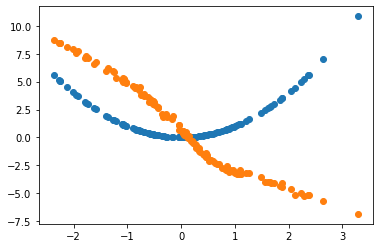

In [16]:
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')

In [17]:
for _ in range(10):
    params = update(params, xs, ys)

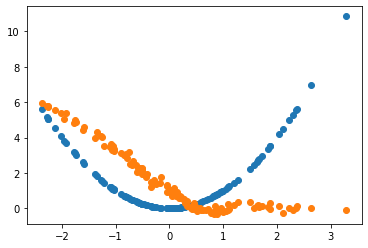

In [18]:
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')

Some more fitting.

In [19]:
for _ in range(1000):
    params = update(params, xs, ys)

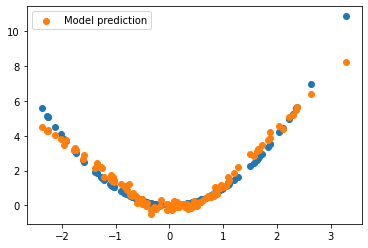

In [20]:
plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend()

Pytrees are more interesting than this. We can even register our own custom classes to be of JAX compatible containers types by defining flattening/unflatten functions.

There are some gotchas to think of when working with pytrees.

- Mistaking nodes for leaves
- Handling of None

Either ways, this is all we're going to look at for today. More on parallel and stateful computations coming up.